In this example, we run the BBHnet over an example GW frame.

In [37]:
import os
import h5py
import glob

import numpy as np
import scipy.signal as sig
import matplotlib as mpl
import matplotlib.pyplot as plt

from gwpy.timeseries import TimeSeries
from gwpy.frequencyseries import FrequencySeries

%matplotlib inline

mpl.rcParams['text.usetex'] = True
mpl.rcParams['font.family'] = 'STIXGeneral'
mpl.rcParams['font.size'] = 16
mpl.rcParams['figure.figsize'] = (8, 6)
mpl.rcParams['figure.facecolor']  = 'w'
mpl.rcParams['savefig.dpi'] = 300
mpl.rcParams['text.latex.preamble'] = r'\usepackage{amsmath}'

In [2]:
# Define some constants
# GPS time of confirmed GW in August 2017
event_tc = [1186302519.8, 1186741861.5, 1187058327.1, 1187529256.5]
event_names = ['GW170809', 'GW170814', 'GW170818', 'GW170823']

# Path to directory with strain
input_dir = '/home/tri.nguyen/gcp_data/strain_4k_splits/'

To demonstrate the ability of the BBHnet to detect GW events, we want to choose a frame that contains a confirmed GW detection. In this example, we will run on the frame containing GW170809.

In [11]:
num_jobs = 18  # number of mini-jobs

# GPS time and name of GW170809
tc = event_tc[0]
name = event_names[0]

# First we want to search for the frame containing GW170809 based on GPS time
# Loop over all mini-jobs

H1_input_file = None
L1_input_file = None
for i_job in range(num_jobs):

    # query all input files (either H1 or L1 is fine)
    input_files = sorted(glob.glob(os.path.join(input_dir, '{}/H1/*'.format(i_job))))
        
    # loop over all input files
    # get GPS of each file and compare with GPS time of GW170809
    for input_file in input_files:
        base_name = os.path.basename(input_file)
        t_start, T = base_name.split('.')[0].split('-')[-2:]        
        t_start = int(t_start)
        T = int(T)
        t_stop = t_start + T
                
        if (t_start <= tc) & (tc < t_stop):
            H1_input_file = input_file
            L1_input_file = os.path.join(
                input_dir, '{}/L1/L-L1_GWOSC_O2_4KHZ_R1-{:d}-{:d}.gwf'.format(i_job, t_start, T))
            print('Found queried event in:')
            print('- Hanford   : {}'.format(H1_input_file))
            print('- Livingston: {}'.format(L1_input_file))
            break

    # break loop if file is found
    if H1_input_file is not None:
        break

Found queried event in:
- Hanford   : /home/tri.nguyen/gcp_data/strain_4k_splits/5/H1/H-H1_GWOSC_O2_4KHZ_R1-1186301952-1024.gwf
- Livingston: /home/tri.nguyen/gcp_data/strain_4k_splits/5/L1/L-L1_GWOSC_O2_4KHZ_R1-1186301952-1024.gwf


Once we found our GW frame, we will use `gwpy.timeseries.TimeSeries` to quickly read the strain.
`gwpy.timeseries.TimeSeries.read` takes in the path to the frame and the channel name. 
For GWOSC frames, the channel name for Hanford and Livingston are `H1:GWOSC-4KHZ_R1_STRAIN` and `L1:GWOSC-4KHZ_R1_STRAIN` respectively.

We will also preprocess the input strain. The preprocess steps are (in order):

1. **Resample**: 
The GWOSC frame has a sample rate of 4096 Hz and a corresponding Nyquist frequency of 2048 Hz. 
The BBHnet is trained on BBHs with a minimum mass of 25 $M_\odot$. 
A BBH with $m_1=m_2 = 25 M_\odot$ exits the LIGO frequency band at 87 Hz. More massive BBHs will exit at an even lower frequency. 
Therefore, we do not need to use the whole frequency band. We thus resample the frrame to 1024 Hz (Nyquist frequency 512 Hz). This will reduce high frequency noises and inference time.


2. **Bandpassing**:
Below 20-30 Hz, the LIGO strain is not well-calibrated because of seismic noise (which dominates these frequencies). 
Excluding these ferquencies will help reduce noise artifacts in the inference process.
We will bandpass the GW strain from [20, 500] Hz.


3. **Whitening**: 
The LIGO power spectrum densities (PSDs), which measure the power of each frequency in the differential arm length (strain) of the detectors, vary over many orders of magnitude between frequencies (see below). 
By whitening the data, we make sure the power of each frequency has roughly the same order of magnitude. 
In addition, LIGO background PSDs are non-stationary (i.e. rapidly changing as a function of time).
Whitening will help minimize this effect, so we do not have to re-train our detection algorithm between different observing times.

**NOTE: bandpassing had not been applied to the current iteration of the neural network**.

<img src="ligo_noisebudget.jpg" width=600 height=600 />

In [43]:
# Read in GW strain from H1 and L1 detectors
# gwpy.timeseries.TimeSeries takes 
H1_strain = TimeSeries.read(H1_input_file, 'H1:GWOSC-4KHZ_R1_STRAIN')
L1_strain = TimeSeries.read(L1_input_file, 'L1:GWOSC-4KHZ_R1_STRAIN')

# Preprocessing
# First, we resample the input strain to 1024 Hz
sample_rate = 1024
H1_strain = H1_strain.resample(sample_rate)
L1_strain = L1_strain.resample(sample_rate)

# Bandpass the strain from 20 to 500 Hz
# NOTE: the current neural network is not trained on bandpassed strain
# so we will ignore this step for now
# H1_strain = H1_strain.bandpass(20, 500)
# L1_strain = L1_strain.bandpass(20, 500)

# Whitening
# we compute the PSD of the strain using scipy.signal.welch and whiten
# NOTE: in this example, we whiten the strain using its PSD
# this is okay here because the duration of BBHs considered is much les 
# than the duration of the frame
# In the real inference run, we whiten the strain using a running PSD
# computed from past data (excluding the strain itself)
nperseg = int(max(sample_rate*2, 2048))
_, H1_psd = sig.welch(H1_strain.value, fs=sample_rate, nperseg=nperseg)
_, L1_psd = sig.welch(L1_strain.value, fs=sample_rate, nperseg=nperseg)
H1_psd = FrequencySeries(H1_psd, df=sample_rate/nperseg)   # df = sample_rate / nperseg
L1_psd = FrequencySeries(L1_psd, df=sample_rate/nperseg)
H1_strain = H1_strain.whiten(asd=np.sqrt(H1_psd))
L1_strain = L1_strain.whiten(asd=np.sqrt(L1_psd))

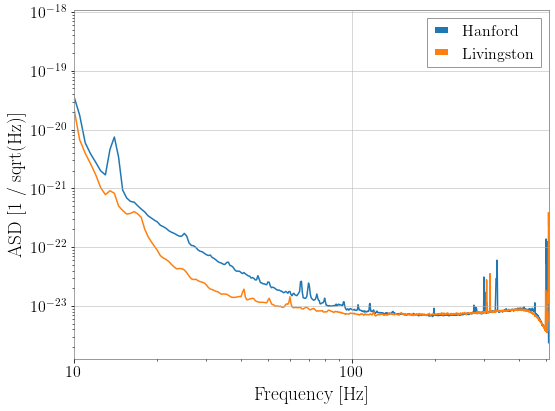

In [44]:
# To double check, we plot the ASD (sqrt of PSD) of H1 and L1
fig, ax = plt.subplots(1)

ax.loglog(H1_psd.frequencies, np.sqrt(H1_psd.value), label='Hanford')
ax.loglog(L1_psd.frequencies, np.sqrt(L1_psd.value), label='Livingston')
ax.set_xlabel('Frequency [Hz]')
ax.set_ylabel('ASD [1 / sqrt(Hz)]')
ax.set_xlim(10, 512)
ax.legend()

fig.tight_layout()

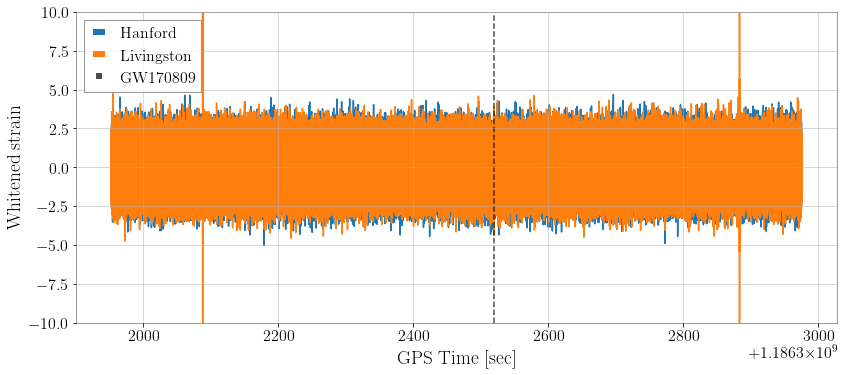

In [92]:
# Also plot the whitened strain for each detector
fig, ax = plt.subplots(1, figsize=(12, 5.5))

ax.plot(H1_strain.times, H1_strain.value, label='Hanford')
ax.plot(L1_strain.times, L1_strain.value, label='Livingston')

# also mark where GW170809 is supposed to be located at
# though we won't be able to see it by eyes
ax.axvline(tc, color='k', ls='--', alpha=.7, label='GW170809')

ax.set_xlabel('GPS Time [sec]')
ax.set_ylabel('Whitened strain')
ax.set_ylim(-10, 10)
ax.legend()

fig.tight_layout()

We see that the PSD and whitened strain look fine. Note that we won't be able to see by eyes GW170809, since the signal is faint. 

We then proceed to create data samples that the BBHnet is able to read in.
The BBHnet takes in a sample size of 1 second, so we will divide the strain into 1-second segments.
Each segment overlaps the previous one by 0.0625 seconds
to minimize edge effects that are caused by glitches at the edges of the sample.

In addition, we will compute the Pearson correlation array between the Hanford and Livingston samples.
To calculate the Pearson correlation array of each sample, we shift the Hanford strain w.r.t the Livingston
strain by [-0.0390625, 0.0390625] seconds, or [-40, 40] samples. 
For each shift, we calculate the Pearson coefficient, defined as:

$$
\rho_{X, Y} = \frac{\mathop{\mathbb{E}}[(X-\mu_X)(Y-\mu_Y)]}{\sigma_X \sigma_Y}
$$

where $X$ and $Y$ are Hanford and Livingston strain in our example.

In [45]:
def as_stride(x, input_size, step, shift=0):
    ''' Divide input time series into overlapping chunk '''
    
    if shift != 0:
        x = np.roll(x, shift)
    
    noverlap = input_size  - step
    N_sample = (x.shape[-1] - noverlap) // step

    shape = (N_sample, input_size)
    strides = x.strides[:-1]+(step*x.strides[-1], x.strides[-1])
    result = np.lib.stride_tricks.as_strided(x, shape=shape, strides=strides)
    
    return result

def pearson_shift(x, y, shift):
    ''' Calculate the Pearson correlation coefficient between x and y
    for each array shift value from [-shift, shift]. 
    '''
    
    x = x - x.mean(axis=1, keepdims=True)
    y = y - y.mean(axis=1, keepdims=True)
    denom = ((x**2).sum(1) * (y**2).sum(1))**0.5

    corr = np.zeros((x.shape[0], shift * 2))
    for i, s in enumerate(range(-shift, shift)):
        xr = np.roll(x, s, axis=1)
        corr[:, i] = (xr * y).sum(1) / denom
    return corr

In [51]:
# Divide Hanford and Livingston into shorter, overlapping segments
input_size = int(sample_rate * 1)
output_sample_rate = 16
step = int(input_size / output_sample_rate)
H1_data = as_stride(H1_strain.value, input_size, step)
L1_data = as_stride(L1_strain.value, input_size, step)

# data with appropriate shape for the BBHnet
data = np.stack([H1_data, L1_data], 1)

# Calculate the Pearson coefficient
shift = 40  # [-40, 40] samples
correlation = pearson_shift(H1_data, L1_data, shift)

Now that we have finished preparing data for the BBHnet.
We will import a trained BBHnet model and run it over the strain. 
The figure below shows an example architecture of the BBHnet.

<img src="bbhnet_arch.png" width=400 height=600 />

**NOTE: the size of the hidden layers in our imported model is larger than shown in the figure, 
but the architecture of the network is the same.**

In [55]:
import torch
import torch.nn as nn
from torch.utils.data import DataLoader

In [56]:
# Define convienient NN block
class ConvBlock(nn.Module):
    def __init__(self, in_channels, out_channels, padding=1):
        super().__init__()
        self.conv = nn.Sequential(
            nn.Conv1d(in_channels, out_channels, 3, padding=padding),
            nn.MaxPool1d(4, 4),
            nn.ReLU(inplace=True),
        )
    def forward(self, x):
        return self.conv(x)
class FCBlock(nn.Module):
    def __init__(self, in_channels, out_channels, dropout_rate=0.5):
        super().__init__()
        self.fc = nn.Sequential(
            nn.Linear(in_channels, out_channels, bias=False),
            nn.ReLU(inplace=True),
            nn.Dropout(dropout_rate),
            nn.BatchNorm1d(out_channels)
        )
    def forward(self, x):
        return self.fc(x)


# Define Classifier
class Classifier(nn.Module):
    def __init__(self, input_shape, corr_dim=0, padding=1):
        super().__init__()

        # nn architecture: CONV + FC -> FC
        # 1D CONV layer for time series data
        self.featurizer = nn.Sequential(
            ConvBlock(input_shape[0], 64, padding=padding),
            ConvBlock(64, 128, padding=padding),
            ConvBlock(128, 256, padding=padding),
            ConvBlock(256, 512, padding=padding)

        )
        # FC layer for Pearson correlation series
        fc_dim = self.get_flattened_size(input_shape)
        if corr_dim > 0:
            self.corr_featurizer = nn.Sequential(
                FCBlock(corr_dim, 32),
                FCBlock(32, 32),
            )
            fc_dim += 32

        # FC classifier combines features output
        self.classifier = nn.Sequential(
            FCBlock(fc_dim, 128),
            FCBlock(128, 64),
            nn.Linear(64, 1),
        )

    def forward(self, x, x_corr=None):
        x = self.featurizer(x)
        x = x.view(x.size(0), -1)
        if x_corr is not None:
            x_corr = self.corr_featurizer(x_corr)
            x = torch.cat([x, x_corr], axis=1)
        x = self.classifier(x)
        return x

    def get_flattened_size(self, input_shape):
        x = torch.rand(1, *input_shape)
        out = self.featurizer(x)
        out_dim = 1
        for i in range(len(out.shape)):
            out_dim *= out.shape[i]
        return out_dim

In [61]:
# Set up GPU/CPU
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# Read in BBHnet
net = Classifier((2, input_size), corr_dim=shift * 2)
net.load_state_dict(torch.load('tutorial_model.pt', map_location='cpu'))
net.to(device)
net.eval()

Classifier(
  (featurizer): Sequential(
    (0): ConvBlock(
      (conv): Sequential(
        (0): Conv1d(2, 64, kernel_size=(3,), stride=(1,), padding=(1,))
        (1): MaxPool1d(kernel_size=4, stride=4, padding=0, dilation=1, ceil_mode=False)
        (2): ReLU(inplace=True)
      )
    )
    (1): ConvBlock(
      (conv): Sequential(
        (0): Conv1d(64, 128, kernel_size=(3,), stride=(1,), padding=(1,))
        (1): MaxPool1d(kernel_size=4, stride=4, padding=0, dilation=1, ceil_mode=False)
        (2): ReLU(inplace=True)
      )
    )
    (2): ConvBlock(
      (conv): Sequential(
        (0): Conv1d(128, 256, kernel_size=(3,), stride=(1,), padding=(1,))
        (1): MaxPool1d(kernel_size=4, stride=4, padding=0, dilation=1, ceil_mode=False)
        (2): ReLU(inplace=True)
      )
    )
    (3): ConvBlock(
      (conv): Sequential(
        (0): Conv1d(256, 512, kernel_size=(3,), stride=(1,), padding=(1,))
        (1): MaxPool1d(kernel_size=4, stride=4, padding=0, dilation=1, ceil_mo

Begin inference process. We only run on 1024 seconds, so the inference should not take too long (about 3-4 seconds on GPU).

In [77]:
# Loading all data at once may take too much memory
# we will use PyTorch DataLoader to help
data_loader = DataLoader(list(zip(data, correlation)), batch_size=1000)

# Start inference
output = []
with torch.no_grad():
    for batch in data_loader:
        # type conversion and move input to GPU/CPU
        x = batch[0].float().to(device)
        x_corr = batch[1].float().to(device)
        
        # inference
        output_batch = net(x, x_corr)
        output.append(output_batch.cpu().numpy())
output = np.concatenate(output)
output = output.ravel()  # convert shape from [N, 1] to [N, ]

# also keeping track of the time at the **start** of the sample
t = H1_strain.t0.value + np.arange(0, len(output)) / output_sample_rate

To see if the BBHnet has successfully detected GW170809, we plot its output as a function of GPS time and mark the location of GW170809.

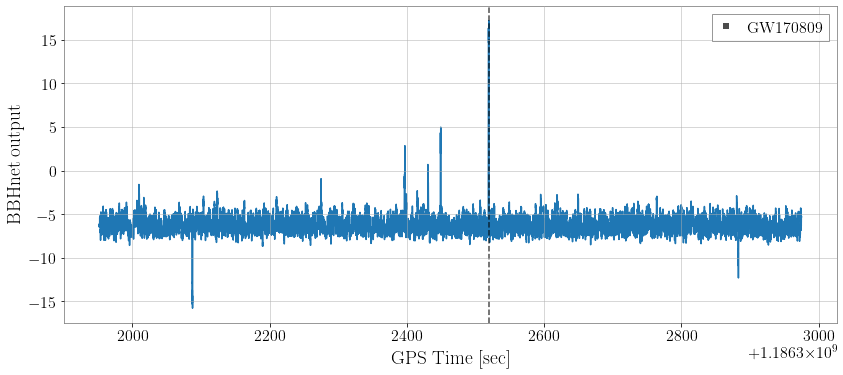

In [98]:
fig, ax = plt.subplots(1, figsize=(12, 5.5))

ax.plot(t, output)

# mark where GW170809 is supposed to be located at
ax.axvline(tc, color='k', ls='--', alpha=.7, label='GW170809')

ax.set_xlabel('GPS Time [sec]')
ax.set_ylabel('BBHnet output')
ax.legend()

fig.tight_layout()

At the GPS time of GW170809, there is a significant increase in the output of the BBHnet. 
This means that the BBHnet has successfully detect GW170809!
Lastly, we will plot the same figure, but zoom in near GW170809.

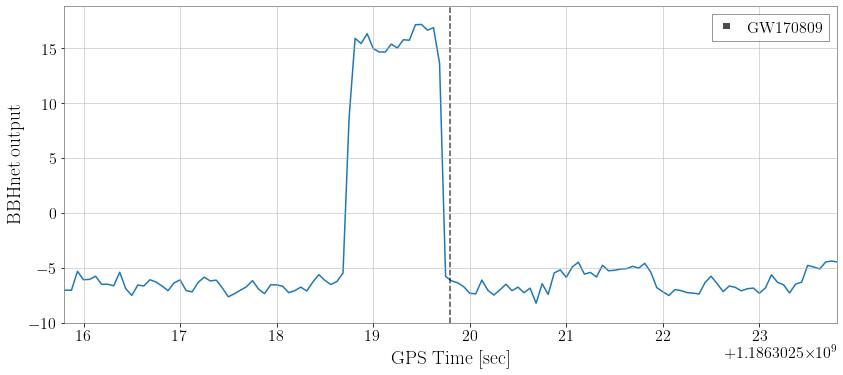

In [103]:
fig, ax = plt.subplots(1, figsize=(12, 5.5))

ax.plot(t, output)

# mark where GW170809 is supposed to be located at
ax.axvline(tc, color='k', ls='--', alpha=.7, label='GW170809')

ax.set_xlabel('GPS Time [sec]')
ax.set_ylabel('BBHnet output')
ax.set_xlim(tc - 4, tc + 4)  # zoom-in
ax.set_ylim(-10, None)
ax.legend()

fig.tight_layout()

We see a significant increase in the score for about 1 second. 
This is because the BBHnet takes in a 1-second sample size and because the data samples are overlapping. 
In other words, the BBHnet detects GW170809 multiple times, each at a different location w.r.t to the input sample.
Glitches, on the other hand, can only trigger when they are at the edge of the input sample and thus cannot trigger multiple times.